# Introduction

In a previous project, we explore Q-Learning. In this one, we saw the limits in term of state space as the Q matrix has a size which should contain all possible state. Knowing that, DeepMind got the idea to use a Neural Network to compute the Q-Value based on the state. This can be seens as an online-regression training. The benefit is allows an infinite number of states. Of course, the more complex, will be the environment, the more complex neural network we will need to approach the estimated Q-Value.

Today, we gonna create the first DeepQNetwork on the environment cartpole. I selected Cartpole for 3 reasons :

- We need an environment with discrete output (so this removes the Pendulum env.)
- To ease the training, I wanted to avoid very sparse reward (this removes MountainCar and Acrobot)
- The environment is small so we don't need a big model and it's gonna be fast to test and tune.

# Creates Model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from collections import deque
import numpy as np
import pickle 
import gym

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Memory Replay

One huge improvement provided by DeepMind team is to train the DQN with a Memory Replay. The idea is to store several pairs of (State, Action, Reward, Next_State) and pick random experiences to train the model instead of the few last tries. The reason is simple. Without Memory Replay, you will get correlations between experiences and creates a poor training. Let's imagine you succeed to maintain the pole perfectly vertical for 20 frames and you use the last 20 frames for your training, you will highly impact the "stability" of the Neural Network. Instead, if you use 20 random frame in a batch of you last 1000 frames, you will have more chances to get frames with pole to the left, to the right, every actions and so on.

Now to implement it, it's quite simple. We just have to store pairs in a Deque (Double Ended Queue) and pick some random elements for the learning.

In [2]:
class Memory():
    """
    Replay Memory slightly extended to compare the impact on the learning of having or not the Memory Replay. 
    Without it, it's just like storing the batch_size of last experiences.
    """
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[x] for x in idx]
    
    def getAll(self):
        return self.buffer
    
    def __len__(self):
        return len(self.buffer)
    
class Stats():
    def __init__(self, max_size=None):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, score):
        self.buffer.append(score)

### DQN

Now let's create our DQN. This is quite simple with Keras, it's like creating a MultiClass Regression Model. The Input is the state and the output is the predicted Q-value of every actions. 

As a result, the label will be the Q-value predicted the the value of the action taken corrected with the result of the Bellmann Equation. For example:

- The model predict [0.1, 0.7] as Q-value for action 0 and 1
- We take, using Epsilon Greedy rule, the action 0
- The reward of this action is 1 <b>and game is not done</b>
- The prediction on the <b>new State</b> provides a Q-value of [0.5, 0.4]
- With a gamma of 0.99, the Q_value of action 0 is : 1 (reward) + 0.99(gamma) * 0.5 (max Next_Q) = 1.495
- The target will be in that case : [1.495, 0.7]

If the game is done, the we only keep the reward so the taget will be :
- The target will be in that case : [1.0, 0.7]

For the training, the principle is exactly the same as Q-Learning except that we perform the "fit" on a batch taken from the replay memory instad of only the last action.

In [3]:
class QNetwork:
    def __init__(self, learning_rate=0.001, use_replay_memory=True, reshape_reward=False):
        self.train_episodes = 1000          # max number of episodes to learn from
        self.test_episodes = 100
        self.max_steps = 200                # max steps in an episode
        self.gamma = 0.99                   # future reward discount

        # Exploration parameters
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = 0.0002            # exponential decay rate for exploration prob

        # Network parameters
        self.hidden_size = 16               # number of units in each Q-network hidden layer
        self.learning_rate = learning_rate
        
        # Benchmark info
        self.stats = Stats(max_size=None)
        self.use_replay_memory = use_replay_memory
        self.reshape_reward = reshape_reward

        # Memory parameters
        self.batch_size = 32 
        if not self.use_replay_memory:
            self.memory_size = self.batch_size       # Store only a batch
            self.pretrain_length = self.batch_size   # number experiences to pretrain the memory
        else:
            self.memory_size = 10000            # memory capacity 
            self.pretrain_length = 10000        # number experiences to pretrain the memory
        self.replay_memory = Memory(max_size=self.memory_size)
        
        # env parameters
        self.input_shape = (4)
        self.output_shape = 2      
        
        self.create_model()
        self.env = gym.make('CartPole-v0')
    
    def create_model(self):
        K.clear_session()
        
        self.model = Sequential()

        self.model.add(Dense(self.hidden_size, activation='relu', input_dim=self.input_shape))
        self.model.add(Dense(self.hidden_size, activation='relu'))
        self.model.add(Dense(self.output_shape, activation='linear'))

        self.optimizer = Adam(lr=self.learning_rate)
        self.model.compile(loss='mse', optimizer=self.optimizer)
        self.model.summary()
        
    def fill_replay(self):
        done = True
        while len(self.replay_memory) < self.pretrain_length:
            if done:
                obs = self.env.reset()
                state = self.obs_to_state(obs)
            else:
                state = next_state
            
            action = self.env.action_space.sample()
            next_obs, reward, done, _ = self.env.step(action)
            next_state = self.obs_to_state(next_obs)
            self.replay_memory.add((state, action, reward, next_state, 1.0-done))
            
    def obs_to_state(self, obs):
        return np.reshape(obs, [1, 4])
    
    def densify_reward(self, obs):
        score_position = (2.4-abs(obs[0]))**2/2.4**2
        score_angle =(0.20944-abs(obs[2]))**2/0.20944**2
        return (score_position + score_angle) /2
    
    def epsilon_greedy(self, step):
        explore_p = self.explore_stop + (self.explore_start - self.explore_stop)*np.exp(-self.decay_rate*step)
        return explore_p
    
    def plot_epsilon_greedy(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,6))
        X = np.arange(1, 10000, 5)
        y = self.epsilon_greedy(X)
        plt.plot(X, y)
        plt.show()
        
    def learn(self, minibatch):
        state_mat = np.zeros((self.batch_size, 4))
        action_arr = np.zeros(self.batch_size, dtype=np.int32)
        rewards_arr = np.zeros(self.batch_size)
        next_state_mat = np.zeros((self.batch_size, 4))
        cont_arr = np.zeros(self.batch_size, dtype=np.int32)
        for i, (state_b, action_b, reward_b, next_state_b, cont) in enumerate(minibatch):
            state_mat[i] = state_b[0]
            action_arr[i] = action_b
            rewards_arr[i] = reward_b
            next_state_mat[i] = next_state_b[0]
            cont_arr[i] = cont
        Q_values = self.model.predict(state_mat)
        next_Q_values = self.model.predict(next_state_mat)
        for i in range(self.batch_size):
            Q_values[i, action_arr[i]] = rewards_arr[i] + cont_arr[i] * self.gamma * np.max(next_Q_values[i])
        self.model.fit(state_mat, Q_values, epochs=1, verbose=0)  #, callbacks=[self.learning_rate]
    
    def train(self, train_episodes_ovr = None):
        self.fill_replay()
        
        if train_episodes_ovr is not None:
            self.train_episodes = train_episodes_ovr
        
        training_step = 0
        for episodes in range(self.train_episodes):
            obs = self.env.reset()
            state = self.obs_to_state(obs)
            
            total_reward = 0
            total_dense_reward = 0
            t = 0
            while t < self.max_steps:
                training_step += 1
                
                exploration_prob = self.epsilon_greedy(training_step)
                if np.random.rand() < exploration_prob:
                    action = self.env.action_space.sample()
                else:
                    Qs = self.model.predict(state)
                    action = np.argmax(Qs[0])

                # Take action, get new state and reward
                next_obs, reward, done, _ = self.env.step(action)
                next_state = self.obs_to_state(next_obs)
                
                dense_reward = self.densify_reward(next_obs)
                if self.reshape_reward:
                    reward_used = reward
                else:
                    reward_used = dense_reward
                
                total_reward += reward
                total_dense_reward += dense_reward
                
                self.replay_memory.add((state, action, reward_used, next_state, 1-done))
                
                # Replay
                if self.use_replay_memory:
                    minibatch = self.replay_memory.sample(self.batch_size)
                else:
                    minibatch = self.replay_memory.getAll()
                self.learn(minibatch)                        
                
                if done:
                    self.stats.add((t, total_reward, total_dense_reward))
                    break
                else:
                    state = next_state
                    t += 1
            
            print('Episode: {}/{}'.format(episodes, self.train_episodes),
                  'Total reward: {}'.format(total_reward),
                  'iter : {}'.format(training_step),
                  'P : {:.3f}'.format(exploration_prob)
                 )
            
    def save_stats(self, filename):
        with open(filename, "wb") as f:
            pickle.dump(self.stats, f)
        
    def play(self, render=False):
        for i in range(self.test_episodes):
            obs = self.env.reset()
            done = False
            total_reward = 0
            while not done:
                if render:
                    self.env.render()
                state = self.obs_to_state(obs)
                Qs = self.model.predict(state)
                action = np.argmax(Qs[0])
                obs, reward, done, _ = self.env.step(action)
                total_reward += reward
            print("Game {} - Score {}".format(i, total_reward))

Now let's try some models. First of all, we can train the same model with and without Replay Memory. We can try to reshape the reward to help the learning (the reward is 1 if we are exactly on the middle with a pole angle of 0) else it decrease to 0 in the worst case (12 deg angle and X position close to +/- 2.4). To finish, I also try smaller and bigger Learning Rate (and decay factor for the epsilon greedy as we need less iterations to learn)

In [4]:
# DQN = QNetwork(learning_rate = 0.0001, use_replay_memory=True, reshape_reward=False)
# DQN.decay_rate = 0.0003
# DQN.plot_epsilon_greedy()

In [9]:
DQN = QNetwork(learning_rate = 0.001, use_replay_memory=True, reshape_reward=False)
DQN.train(train_episodes_ovr=1000)
DQN.save_stats("DQN_with_memory_simple_reward.p")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 Total reward: 10.0 iter : 10 P : 0.998
Episode: 1/1000 Total reward: 32.0 iter : 42 P : 0.992
Episode: 2/1000 Total reward: 9.0 iter : 51 P : 0.990
Episode: 3/1000 Total reward: 12.0 iter : 63 P : 0.988
Episode: 4/1000 Total reward: 19.0 iter : 82 P : 0.984
Episode: 5/1000 Total reward: 16.0 iter : 98 P : 0.981
Episode: 6/1000 Total reward: 11.0 iter : 109 P : 0.979
Episode: 7/1000 Total r

Episode: 130/1000 Total reward: 200.0 iter : 6469 P : 0.281
Episode: 131/1000 Total reward: 200.0 iter : 6669 P : 0.271
Episode: 132/1000 Total reward: 200.0 iter : 6869 P : 0.261
Episode: 133/1000 Total reward: 200.0 iter : 7069 P : 0.251
Episode: 134/1000 Total reward: 177.0 iter : 7246 P : 0.242
Episode: 135/1000 Total reward: 200.0 iter : 7446 P : 0.233
Episode: 136/1000 Total reward: 200.0 iter : 7646 P : 0.225
Episode: 137/1000 Total reward: 187.0 iter : 7833 P : 0.217
Episode: 138/1000 Total reward: 200.0 iter : 8033 P : 0.209
Episode: 139/1000 Total reward: 200.0 iter : 8233 P : 0.201
Episode: 140/1000 Total reward: 200.0 iter : 8433 P : 0.193
Episode: 141/1000 Total reward: 198.0 iter : 8631 P : 0.186
Episode: 142/1000 Total reward: 200.0 iter : 8831 P : 0.179
Episode: 143/1000 Total reward: 200.0 iter : 9031 P : 0.173
Episode: 144/1000 Total reward: 200.0 iter : 9231 P : 0.166
Episode: 145/1000 Total reward: 200.0 iter : 9431 P : 0.160
Episode: 146/1000 Total reward: 200.0 it

Episode: 266/1000 Total reward: 200.0 iter : 25729 P : 0.016
Episode: 267/1000 Total reward: 200.0 iter : 25929 P : 0.016
Episode: 268/1000 Total reward: 200.0 iter : 26129 P : 0.015
Episode: 269/1000 Total reward: 200.0 iter : 26329 P : 0.015
Episode: 270/1000 Total reward: 200.0 iter : 26529 P : 0.015
Episode: 271/1000 Total reward: 200.0 iter : 26729 P : 0.015
Episode: 272/1000 Total reward: 200.0 iter : 26929 P : 0.015
Episode: 273/1000 Total reward: 200.0 iter : 27129 P : 0.014
Episode: 274/1000 Total reward: 200.0 iter : 27329 P : 0.014
Episode: 275/1000 Total reward: 200.0 iter : 27529 P : 0.014
Episode: 276/1000 Total reward: 200.0 iter : 27729 P : 0.014
Episode: 277/1000 Total reward: 200.0 iter : 27929 P : 0.014
Episode: 278/1000 Total reward: 200.0 iter : 28129 P : 0.014
Episode: 279/1000 Total reward: 200.0 iter : 28329 P : 0.013
Episode: 280/1000 Total reward: 200.0 iter : 28529 P : 0.013
Episode: 281/1000 Total reward: 200.0 iter : 28729 P : 0.013
Episode: 282/1000 Total 

Episode: 401/1000 Total reward: 185.0 iter : 46823 P : 0.010
Episode: 402/1000 Total reward: 191.0 iter : 47014 P : 0.010
Episode: 403/1000 Total reward: 195.0 iter : 47209 P : 0.010
Episode: 404/1000 Total reward: 200.0 iter : 47409 P : 0.010
Episode: 405/1000 Total reward: 200.0 iter : 47609 P : 0.010
Episode: 406/1000 Total reward: 200.0 iter : 47809 P : 0.010
Episode: 407/1000 Total reward: 200.0 iter : 48009 P : 0.010
Episode: 408/1000 Total reward: 200.0 iter : 48209 P : 0.010
Episode: 409/1000 Total reward: 200.0 iter : 48409 P : 0.010
Episode: 410/1000 Total reward: 200.0 iter : 48609 P : 0.010
Episode: 411/1000 Total reward: 166.0 iter : 48775 P : 0.010
Episode: 412/1000 Total reward: 200.0 iter : 48975 P : 0.010
Episode: 413/1000 Total reward: 200.0 iter : 49175 P : 0.010
Episode: 414/1000 Total reward: 200.0 iter : 49375 P : 0.010
Episode: 415/1000 Total reward: 200.0 iter : 49575 P : 0.010
Episode: 416/1000 Total reward: 192.0 iter : 49767 P : 0.010
Episode: 417/1000 Total 

Episode: 538/1000 Total reward: 9.0 iter : 67047 P : 0.010
Episode: 539/1000 Total reward: 10.0 iter : 67057 P : 0.010
Episode: 540/1000 Total reward: 10.0 iter : 67067 P : 0.010
Episode: 541/1000 Total reward: 11.0 iter : 67078 P : 0.010
Episode: 542/1000 Total reward: 9.0 iter : 67087 P : 0.010
Episode: 543/1000 Total reward: 9.0 iter : 67096 P : 0.010
Episode: 544/1000 Total reward: 10.0 iter : 67106 P : 0.010
Episode: 545/1000 Total reward: 10.0 iter : 67116 P : 0.010
Episode: 546/1000 Total reward: 9.0 iter : 67125 P : 0.010
Episode: 547/1000 Total reward: 10.0 iter : 67135 P : 0.010
Episode: 548/1000 Total reward: 9.0 iter : 67144 P : 0.010
Episode: 549/1000 Total reward: 10.0 iter : 67154 P : 0.010
Episode: 550/1000 Total reward: 9.0 iter : 67163 P : 0.010
Episode: 551/1000 Total reward: 9.0 iter : 67172 P : 0.010
Episode: 552/1000 Total reward: 8.0 iter : 67180 P : 0.010
Episode: 553/1000 Total reward: 10.0 iter : 67190 P : 0.010
Episode: 554/1000 Total reward: 8.0 iter : 67198

Episode: 679/1000 Total reward: 10.0 iter : 77652 P : 0.010
Episode: 680/1000 Total reward: 10.0 iter : 77662 P : 0.010
Episode: 681/1000 Total reward: 10.0 iter : 77672 P : 0.010
Episode: 682/1000 Total reward: 10.0 iter : 77682 P : 0.010
Episode: 683/1000 Total reward: 10.0 iter : 77692 P : 0.010
Episode: 684/1000 Total reward: 9.0 iter : 77701 P : 0.010
Episode: 685/1000 Total reward: 10.0 iter : 77711 P : 0.010
Episode: 686/1000 Total reward: 9.0 iter : 77720 P : 0.010
Episode: 687/1000 Total reward: 9.0 iter : 77729 P : 0.010
Episode: 688/1000 Total reward: 9.0 iter : 77738 P : 0.010
Episode: 689/1000 Total reward: 10.0 iter : 77748 P : 0.010
Episode: 690/1000 Total reward: 9.0 iter : 77757 P : 0.010
Episode: 691/1000 Total reward: 10.0 iter : 77767 P : 0.010
Episode: 692/1000 Total reward: 8.0 iter : 77775 P : 0.010
Episode: 693/1000 Total reward: 9.0 iter : 77784 P : 0.010
Episode: 694/1000 Total reward: 9.0 iter : 77793 P : 0.010
Episode: 695/1000 Total reward: 10.0 iter : 7780

Episode: 819/1000 Total reward: 11.0 iter : 83870 P : 0.010
Episode: 820/1000 Total reward: 13.0 iter : 83883 P : 0.010
Episode: 821/1000 Total reward: 12.0 iter : 83895 P : 0.010
Episode: 822/1000 Total reward: 10.0 iter : 83905 P : 0.010
Episode: 823/1000 Total reward: 14.0 iter : 83919 P : 0.010
Episode: 824/1000 Total reward: 13.0 iter : 83932 P : 0.010
Episode: 825/1000 Total reward: 200.0 iter : 84132 P : 0.010
Episode: 826/1000 Total reward: 164.0 iter : 84296 P : 0.010
Episode: 827/1000 Total reward: 111.0 iter : 84407 P : 0.010
Episode: 828/1000 Total reward: 105.0 iter : 84512 P : 0.010
Episode: 829/1000 Total reward: 95.0 iter : 84607 P : 0.010
Episode: 830/1000 Total reward: 106.0 iter : 84713 P : 0.010
Episode: 831/1000 Total reward: 21.0 iter : 84734 P : 0.010
Episode: 832/1000 Total reward: 96.0 iter : 84830 P : 0.010
Episode: 833/1000 Total reward: 104.0 iter : 84934 P : 0.010
Episode: 834/1000 Total reward: 105.0 iter : 85039 P : 0.010
Episode: 835/1000 Total reward: 1

Episode: 955/1000 Total reward: 157.0 iter : 96954 P : 0.010
Episode: 956/1000 Total reward: 13.0 iter : 96967 P : 0.010
Episode: 957/1000 Total reward: 14.0 iter : 96981 P : 0.010
Episode: 958/1000 Total reward: 17.0 iter : 96998 P : 0.010
Episode: 959/1000 Total reward: 14.0 iter : 97012 P : 0.010
Episode: 960/1000 Total reward: 10.0 iter : 97022 P : 0.010
Episode: 961/1000 Total reward: 11.0 iter : 97033 P : 0.010
Episode: 962/1000 Total reward: 11.0 iter : 97044 P : 0.010
Episode: 963/1000 Total reward: 12.0 iter : 97056 P : 0.010
Episode: 964/1000 Total reward: 12.0 iter : 97068 P : 0.010
Episode: 965/1000 Total reward: 11.0 iter : 97079 P : 0.010
Episode: 966/1000 Total reward: 12.0 iter : 97091 P : 0.010
Episode: 967/1000 Total reward: 10.0 iter : 97101 P : 0.010
Episode: 968/1000 Total reward: 9.0 iter : 97110 P : 0.010
Episode: 969/1000 Total reward: 9.0 iter : 97119 P : 0.010
Episode: 970/1000 Total reward: 8.0 iter : 97127 P : 0.010
Episode: 971/1000 Total reward: 11.0 iter 

We can test the lastest model on a play (without Replay Memory and with dense reward). It may be a bad score and we will see why in the next part.

In [8]:
DQN.play(render = False)

Game 0 - Score 200.0
Game 1 - Score 200.0
Game 2 - Score 200.0
Game 3 - Score 200.0
Game 4 - Score 200.0
Game 5 - Score 200.0
Game 6 - Score 200.0
Game 7 - Score 200.0
Game 8 - Score 200.0
Game 9 - Score 200.0
Game 10 - Score 200.0
Game 11 - Score 200.0
Game 12 - Score 200.0
Game 13 - Score 200.0
Game 14 - Score 200.0
Game 15 - Score 200.0
Game 16 - Score 200.0
Game 17 - Score 200.0
Game 18 - Score 200.0
Game 19 - Score 200.0
Game 20 - Score 200.0
Game 21 - Score 194.0
Game 22 - Score 200.0
Game 23 - Score 200.0
Game 24 - Score 200.0
Game 25 - Score 200.0
Game 26 - Score 200.0
Game 27 - Score 200.0
Game 28 - Score 200.0
Game 29 - Score 200.0
Game 30 - Score 200.0
Game 31 - Score 200.0
Game 32 - Score 200.0
Game 33 - Score 200.0
Game 34 - Score 200.0
Game 35 - Score 200.0
Game 36 - Score 200.0
Game 37 - Score 200.0
Game 38 - Score 197.0
Game 39 - Score 200.0
Game 40 - Score 200.0
Game 41 - Score 200.0
Game 42 - Score 200.0
Game 43 - Score 200.0
Game 44 - Score 200.0
Game 45 - Score 200.

In [6]:
DQN = QNetwork(learning_rate = 0.001, use_replay_memory=True, reshape_reward=True)
DQN.train(train_episodes_ovr=1000)
DQN.save_stats("DQN_with_memory_dense_reward.p")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 Total reward: 10.0 iter : 10 P : 0.998
Episode: 1/1000 Total reward: 12.0 iter : 22 P : 0.996
Episode: 2/1000 Total reward: 10.0 iter : 32 P : 0.994
Episode: 3/1000 Total reward: 26.0 iter : 58 P : 0.989
Episode: 4/1000 Total reward: 33.0 iter : 91 P : 0.982
Episode: 5/1000 Total reward: 26.0 iter : 117 P : 0.977
Episode: 6/1000 Total reward: 15.0 iter : 132 P : 0.974
Episode: 7/1000 Total

Episode: 133/1000 Total reward: 21.0 iter : 2749 P : 0.581
Episode: 134/1000 Total reward: 20.0 iter : 2769 P : 0.579
Episode: 135/1000 Total reward: 21.0 iter : 2790 P : 0.577
Episode: 136/1000 Total reward: 40.0 iter : 2830 P : 0.572
Episode: 137/1000 Total reward: 25.0 iter : 2855 P : 0.569
Episode: 138/1000 Total reward: 16.0 iter : 2871 P : 0.568
Episode: 139/1000 Total reward: 25.0 iter : 2896 P : 0.565
Episode: 140/1000 Total reward: 22.0 iter : 2918 P : 0.562
Episode: 141/1000 Total reward: 19.0 iter : 2937 P : 0.560
Episode: 142/1000 Total reward: 84.0 iter : 3021 P : 0.551
Episode: 143/1000 Total reward: 34.0 iter : 3055 P : 0.547
Episode: 144/1000 Total reward: 26.0 iter : 3081 P : 0.545
Episode: 145/1000 Total reward: 18.0 iter : 3099 P : 0.543
Episode: 146/1000 Total reward: 16.0 iter : 3115 P : 0.541
Episode: 147/1000 Total reward: 13.0 iter : 3128 P : 0.540
Episode: 148/1000 Total reward: 12.0 iter : 3140 P : 0.538
Episode: 149/1000 Total reward: 38.0 iter : 3178 P : 0.5

Episode: 272/1000 Total reward: 200.0 iter : 11549 P : 0.108
Episode: 273/1000 Total reward: 200.0 iter : 11749 P : 0.104
Episode: 274/1000 Total reward: 200.0 iter : 11949 P : 0.101
Episode: 275/1000 Total reward: 200.0 iter : 12149 P : 0.097
Episode: 276/1000 Total reward: 197.0 iter : 12346 P : 0.094
Episode: 277/1000 Total reward: 200.0 iter : 12546 P : 0.091
Episode: 278/1000 Total reward: 192.0 iter : 12738 P : 0.087
Episode: 279/1000 Total reward: 198.0 iter : 12936 P : 0.084
Episode: 280/1000 Total reward: 165.0 iter : 13101 P : 0.082
Episode: 281/1000 Total reward: 196.0 iter : 13297 P : 0.079
Episode: 282/1000 Total reward: 179.0 iter : 13476 P : 0.077
Episode: 283/1000 Total reward: 178.0 iter : 13654 P : 0.075
Episode: 284/1000 Total reward: 196.0 iter : 13850 P : 0.072
Episode: 285/1000 Total reward: 147.0 iter : 13997 P : 0.070
Episode: 286/1000 Total reward: 162.0 iter : 14159 P : 0.068
Episode: 287/1000 Total reward: 159.0 iter : 14318 P : 0.066
Episode: 288/1000 Total 

Episode: 408/1000 Total reward: 109.0 iter : 25561 P : 0.016
Episode: 409/1000 Total reward: 88.0 iter : 25649 P : 0.016
Episode: 410/1000 Total reward: 90.0 iter : 25739 P : 0.016
Episode: 411/1000 Total reward: 74.0 iter : 25813 P : 0.016
Episode: 412/1000 Total reward: 90.0 iter : 25903 P : 0.016
Episode: 413/1000 Total reward: 76.0 iter : 25979 P : 0.015
Episode: 414/1000 Total reward: 78.0 iter : 26057 P : 0.015
Episode: 415/1000 Total reward: 84.0 iter : 26141 P : 0.015
Episode: 416/1000 Total reward: 100.0 iter : 26241 P : 0.015
Episode: 417/1000 Total reward: 98.0 iter : 26339 P : 0.015
Episode: 418/1000 Total reward: 119.0 iter : 26458 P : 0.015
Episode: 419/1000 Total reward: 96.0 iter : 26554 P : 0.015
Episode: 420/1000 Total reward: 74.0 iter : 26628 P : 0.015
Episode: 421/1000 Total reward: 106.0 iter : 26734 P : 0.015
Episode: 422/1000 Total reward: 86.0 iter : 26820 P : 0.015
Episode: 423/1000 Total reward: 127.0 iter : 26947 P : 0.015
Episode: 424/1000 Total reward: 96.

Episode: 546/1000 Total reward: 8.0 iter : 44737 P : 0.010
Episode: 547/1000 Total reward: 10.0 iter : 44747 P : 0.010
Episode: 548/1000 Total reward: 10.0 iter : 44757 P : 0.010
Episode: 549/1000 Total reward: 9.0 iter : 44766 P : 0.010
Episode: 550/1000 Total reward: 10.0 iter : 44776 P : 0.010
Episode: 551/1000 Total reward: 10.0 iter : 44786 P : 0.010
Episode: 552/1000 Total reward: 10.0 iter : 44796 P : 0.010
Episode: 553/1000 Total reward: 10.0 iter : 44806 P : 0.010
Episode: 554/1000 Total reward: 9.0 iter : 44815 P : 0.010
Episode: 555/1000 Total reward: 10.0 iter : 44825 P : 0.010
Episode: 556/1000 Total reward: 9.0 iter : 44834 P : 0.010
Episode: 557/1000 Total reward: 10.0 iter : 44844 P : 0.010
Episode: 558/1000 Total reward: 171.0 iter : 45015 P : 0.010
Episode: 559/1000 Total reward: 109.0 iter : 45124 P : 0.010
Episode: 560/1000 Total reward: 100.0 iter : 45224 P : 0.010
Episode: 561/1000 Total reward: 105.0 iter : 45329 P : 0.010
Episode: 562/1000 Total reward: 110.0 it

Episode: 682/1000 Total reward: 28.0 iter : 61705 P : 0.010
Episode: 683/1000 Total reward: 104.0 iter : 61809 P : 0.010
Episode: 684/1000 Total reward: 106.0 iter : 61915 P : 0.010
Episode: 685/1000 Total reward: 99.0 iter : 62014 P : 0.010
Episode: 686/1000 Total reward: 109.0 iter : 62123 P : 0.010
Episode: 687/1000 Total reward: 169.0 iter : 62292 P : 0.010
Episode: 688/1000 Total reward: 200.0 iter : 62492 P : 0.010
Episode: 689/1000 Total reward: 104.0 iter : 62596 P : 0.010
Episode: 690/1000 Total reward: 200.0 iter : 62796 P : 0.010
Episode: 691/1000 Total reward: 200.0 iter : 62996 P : 0.010
Episode: 692/1000 Total reward: 200.0 iter : 63196 P : 0.010
Episode: 693/1000 Total reward: 126.0 iter : 63322 P : 0.010
Episode: 694/1000 Total reward: 200.0 iter : 63522 P : 0.010
Episode: 695/1000 Total reward: 200.0 iter : 63722 P : 0.010
Episode: 696/1000 Total reward: 200.0 iter : 63922 P : 0.010
Episode: 697/1000 Total reward: 122.0 iter : 64044 P : 0.010
Episode: 698/1000 Total re

Episode: 818/1000 Total reward: 28.0 iter : 79798 P : 0.010
Episode: 819/1000 Total reward: 200.0 iter : 79998 P : 0.010
Episode: 820/1000 Total reward: 200.0 iter : 80198 P : 0.010
Episode: 821/1000 Total reward: 200.0 iter : 80398 P : 0.010
Episode: 822/1000 Total reward: 200.0 iter : 80598 P : 0.010
Episode: 823/1000 Total reward: 200.0 iter : 80798 P : 0.010
Episode: 824/1000 Total reward: 200.0 iter : 80998 P : 0.010
Episode: 825/1000 Total reward: 200.0 iter : 81198 P : 0.010
Episode: 826/1000 Total reward: 144.0 iter : 81342 P : 0.010
Episode: 827/1000 Total reward: 112.0 iter : 81454 P : 0.010
Episode: 828/1000 Total reward: 21.0 iter : 81475 P : 0.010
Episode: 829/1000 Total reward: 73.0 iter : 81548 P : 0.010
Episode: 830/1000 Total reward: 10.0 iter : 81558 P : 0.010
Episode: 831/1000 Total reward: 104.0 iter : 81662 P : 0.010
Episode: 832/1000 Total reward: 200.0 iter : 81862 P : 0.010
Episode: 833/1000 Total reward: 200.0 iter : 82062 P : 0.010
Episode: 834/1000 Total rewa

Episode: 954/1000 Total reward: 101.0 iter : 98738 P : 0.010
Episode: 955/1000 Total reward: 24.0 iter : 98762 P : 0.010
Episode: 956/1000 Total reward: 22.0 iter : 98784 P : 0.010
Episode: 957/1000 Total reward: 23.0 iter : 98807 P : 0.010
Episode: 958/1000 Total reward: 23.0 iter : 98830 P : 0.010
Episode: 959/1000 Total reward: 25.0 iter : 98855 P : 0.010
Episode: 960/1000 Total reward: 23.0 iter : 98878 P : 0.010
Episode: 961/1000 Total reward: 22.0 iter : 98900 P : 0.010
Episode: 962/1000 Total reward: 20.0 iter : 98920 P : 0.010
Episode: 963/1000 Total reward: 24.0 iter : 98944 P : 0.010
Episode: 964/1000 Total reward: 36.0 iter : 98980 P : 0.010
Episode: 965/1000 Total reward: 25.0 iter : 99005 P : 0.010
Episode: 966/1000 Total reward: 35.0 iter : 99040 P : 0.010
Episode: 967/1000 Total reward: 31.0 iter : 99071 P : 0.010
Episode: 968/1000 Total reward: 107.0 iter : 99178 P : 0.010
Episode: 969/1000 Total reward: 185.0 iter : 99363 P : 0.010
Episode: 970/1000 Total reward: 124.0

In [7]:
DQN = QNetwork(learning_rate = 0.001, use_replay_memory=False, reshape_reward=False)
DQN.train(train_episodes_ovr=1000)
DQN.save_stats("DQN_without_memory_simple_reward.p")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 Total reward: 32.0 iter : 32 P : 0.994
Episode: 1/1000 Total reward: 13.0 iter : 45 P : 0.991
Episode: 2/1000 Total reward: 12.0 iter : 57 P : 0.989
Episode: 3/1000 Total reward: 19.0 iter : 76 P : 0.985
Episode: 4/1000 Total reward: 27.0 iter : 103 P : 0.980
Episode: 5/1000 Total reward: 10.0 iter : 113 P : 0.978
Episode: 6/1000 Total reward: 31.0 iter : 144 P : 0.972
Episode: 7/1000 Tota

Episode: 269/1000 Total reward: 103.0 iter : 20605 P : 0.026
Episode: 270/1000 Total reward: 200.0 iter : 20805 P : 0.025
Episode: 271/1000 Total reward: 200.0 iter : 21005 P : 0.025
Episode: 272/1000 Total reward: 200.0 iter : 21205 P : 0.024
Episode: 273/1000 Total reward: 200.0 iter : 21405 P : 0.024
Episode: 274/1000 Total reward: 200.0 iter : 21605 P : 0.023
Episode: 275/1000 Total reward: 200.0 iter : 21805 P : 0.023
Episode: 276/1000 Total reward: 200.0 iter : 22005 P : 0.022
Episode: 277/1000 Total reward: 200.0 iter : 22205 P : 0.022
Episode: 278/1000 Total reward: 200.0 iter : 22405 P : 0.021
Episode: 279/1000 Total reward: 200.0 iter : 22605 P : 0.021
Episode: 280/1000 Total reward: 200.0 iter : 22805 P : 0.020
Episode: 281/1000 Total reward: 200.0 iter : 23005 P : 0.020
Episode: 282/1000 Total reward: 200.0 iter : 23205 P : 0.020
Episode: 283/1000 Total reward: 200.0 iter : 23405 P : 0.019
Episode: 284/1000 Total reward: 200.0 iter : 23605 P : 0.019
Episode: 285/1000 Total 

Episode: 407/1000 Total reward: 13.0 iter : 29060 P : 0.013
Episode: 408/1000 Total reward: 14.0 iter : 29074 P : 0.013
Episode: 409/1000 Total reward: 18.0 iter : 29092 P : 0.013
Episode: 410/1000 Total reward: 13.0 iter : 29105 P : 0.013
Episode: 411/1000 Total reward: 16.0 iter : 29121 P : 0.013
Episode: 412/1000 Total reward: 15.0 iter : 29136 P : 0.013
Episode: 413/1000 Total reward: 13.0 iter : 29149 P : 0.013
Episode: 414/1000 Total reward: 15.0 iter : 29164 P : 0.013
Episode: 415/1000 Total reward: 11.0 iter : 29175 P : 0.013
Episode: 416/1000 Total reward: 13.0 iter : 29188 P : 0.013
Episode: 417/1000 Total reward: 10.0 iter : 29198 P : 0.013
Episode: 418/1000 Total reward: 12.0 iter : 29210 P : 0.013
Episode: 419/1000 Total reward: 12.0 iter : 29222 P : 0.013
Episode: 420/1000 Total reward: 22.0 iter : 29244 P : 0.013
Episode: 421/1000 Total reward: 13.0 iter : 29257 P : 0.013
Episode: 422/1000 Total reward: 11.0 iter : 29268 P : 0.013
Episode: 423/1000 Total reward: 18.0 ite

Episode: 546/1000 Total reward: 30.0 iter : 36652 P : 0.011
Episode: 547/1000 Total reward: 22.0 iter : 36674 P : 0.011
Episode: 548/1000 Total reward: 24.0 iter : 36698 P : 0.011
Episode: 549/1000 Total reward: 40.0 iter : 36738 P : 0.011
Episode: 550/1000 Total reward: 25.0 iter : 36763 P : 0.011
Episode: 551/1000 Total reward: 27.0 iter : 36790 P : 0.011
Episode: 552/1000 Total reward: 15.0 iter : 36805 P : 0.011
Episode: 553/1000 Total reward: 13.0 iter : 36818 P : 0.011
Episode: 554/1000 Total reward: 20.0 iter : 36838 P : 0.011
Episode: 555/1000 Total reward: 22.0 iter : 36860 P : 0.011
Episode: 556/1000 Total reward: 18.0 iter : 36878 P : 0.011
Episode: 557/1000 Total reward: 20.0 iter : 36898 P : 0.011
Episode: 558/1000 Total reward: 22.0 iter : 36920 P : 0.011
Episode: 559/1000 Total reward: 15.0 iter : 36935 P : 0.011
Episode: 560/1000 Total reward: 20.0 iter : 36955 P : 0.011
Episode: 561/1000 Total reward: 21.0 iter : 36976 P : 0.011
Episode: 562/1000 Total reward: 15.0 ite

Episode: 683/1000 Total reward: 200.0 iter : 46966 P : 0.010
Episode: 684/1000 Total reward: 17.0 iter : 46983 P : 0.010
Episode: 685/1000 Total reward: 200.0 iter : 47183 P : 0.010
Episode: 686/1000 Total reward: 47.0 iter : 47230 P : 0.010
Episode: 687/1000 Total reward: 200.0 iter : 47430 P : 0.010
Episode: 688/1000 Total reward: 18.0 iter : 47448 P : 0.010
Episode: 689/1000 Total reward: 200.0 iter : 47648 P : 0.010
Episode: 690/1000 Total reward: 200.0 iter : 47848 P : 0.010
Episode: 691/1000 Total reward: 200.0 iter : 48048 P : 0.010
Episode: 692/1000 Total reward: 200.0 iter : 48248 P : 0.010
Episode: 693/1000 Total reward: 200.0 iter : 48448 P : 0.010
Episode: 694/1000 Total reward: 200.0 iter : 48648 P : 0.010
Episode: 695/1000 Total reward: 200.0 iter : 48848 P : 0.010
Episode: 696/1000 Total reward: 200.0 iter : 49048 P : 0.010
Episode: 697/1000 Total reward: 200.0 iter : 49248 P : 0.010
Episode: 698/1000 Total reward: 200.0 iter : 49448 P : 0.010
Episode: 699/1000 Total rew

Episode: 818/1000 Total reward: 42.0 iter : 68308 P : 0.010
Episode: 819/1000 Total reward: 46.0 iter : 68354 P : 0.010
Episode: 820/1000 Total reward: 48.0 iter : 68402 P : 0.010
Episode: 821/1000 Total reward: 53.0 iter : 68455 P : 0.010
Episode: 822/1000 Total reward: 55.0 iter : 68510 P : 0.010
Episode: 823/1000 Total reward: 76.0 iter : 68586 P : 0.010
Episode: 824/1000 Total reward: 71.0 iter : 68657 P : 0.010
Episode: 825/1000 Total reward: 75.0 iter : 68732 P : 0.010
Episode: 826/1000 Total reward: 70.0 iter : 68802 P : 0.010
Episode: 827/1000 Total reward: 59.0 iter : 68861 P : 0.010
Episode: 828/1000 Total reward: 88.0 iter : 68949 P : 0.010
Episode: 829/1000 Total reward: 110.0 iter : 69059 P : 0.010
Episode: 830/1000 Total reward: 200.0 iter : 69259 P : 0.010
Episode: 831/1000 Total reward: 56.0 iter : 69315 P : 0.010
Episode: 832/1000 Total reward: 200.0 iter : 69515 P : 0.010
Episode: 833/1000 Total reward: 200.0 iter : 69715 P : 0.010
Episode: 834/1000 Total reward: 85.0

Episode: 953/1000 Total reward: 131.0 iter : 91880 P : 0.010
Episode: 954/1000 Total reward: 8.0 iter : 91888 P : 0.010
Episode: 955/1000 Total reward: 10.0 iter : 91898 P : 0.010
Episode: 956/1000 Total reward: 69.0 iter : 91967 P : 0.010
Episode: 957/1000 Total reward: 109.0 iter : 92076 P : 0.010
Episode: 958/1000 Total reward: 140.0 iter : 92216 P : 0.010
Episode: 959/1000 Total reward: 164.0 iter : 92380 P : 0.010
Episode: 960/1000 Total reward: 160.0 iter : 92540 P : 0.010
Episode: 961/1000 Total reward: 200.0 iter : 92740 P : 0.010
Episode: 962/1000 Total reward: 64.0 iter : 92804 P : 0.010
Episode: 963/1000 Total reward: 76.0 iter : 92880 P : 0.010
Episode: 964/1000 Total reward: 150.0 iter : 93030 P : 0.010
Episode: 965/1000 Total reward: 200.0 iter : 93230 P : 0.010
Episode: 966/1000 Total reward: 116.0 iter : 93346 P : 0.010
Episode: 967/1000 Total reward: 200.0 iter : 93546 P : 0.010
Episode: 968/1000 Total reward: 200.0 iter : 93746 P : 0.010
Episode: 969/1000 Total reward

In [8]:
DQN = QNetwork(learning_rate = 0.001, use_replay_memory=False, reshape_reward=True)
DQN.train(train_episodes_ovr=1000)
DQN.save_stats("DQN_without_memory_dense_reward.p")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
Episode: 0/1000 Total reward: 12.0 iter : 12 P : 0.998
Episode: 1/1000 Total reward: 29.0 iter : 41 P : 0.992
Episode: 2/1000 Total reward: 46.0 iter : 87 P : 0.983
Episode: 3/1000 Total reward: 23.0 iter : 110 P : 0.978
Episode: 4/1000 Total reward: 30.0 iter : 140 P : 0.973
Episode: 5/1000 Total reward: 41.0 iter : 181 P : 0.965
Episode: 6/1000 Total reward: 27.0 iter : 208 P : 0.960
Episode: 7/1000 Tot

Episode: 131/1000 Total reward: 13.0 iter : 4376 P : 0.423
Episode: 132/1000 Total reward: 32.0 iter : 4408 P : 0.420
Episode: 133/1000 Total reward: 46.0 iter : 4454 P : 0.416
Episode: 134/1000 Total reward: 70.0 iter : 4524 P : 0.411
Episode: 135/1000 Total reward: 103.0 iter : 4627 P : 0.402
Episode: 136/1000 Total reward: 62.0 iter : 4689 P : 0.398
Episode: 137/1000 Total reward: 43.0 iter : 4732 P : 0.394
Episode: 138/1000 Total reward: 41.0 iter : 4773 P : 0.391
Episode: 139/1000 Total reward: 76.0 iter : 4849 P : 0.385
Episode: 140/1000 Total reward: 189.0 iter : 5038 P : 0.371
Episode: 141/1000 Total reward: 62.0 iter : 5100 P : 0.367
Episode: 142/1000 Total reward: 138.0 iter : 5238 P : 0.357
Episode: 143/1000 Total reward: 68.0 iter : 5306 P : 0.353
Episode: 144/1000 Total reward: 23.0 iter : 5329 P : 0.351
Episode: 145/1000 Total reward: 47.0 iter : 5376 P : 0.348
Episode: 146/1000 Total reward: 92.0 iter : 5468 P : 0.342
Episode: 147/1000 Total reward: 39.0 iter : 5507 P : 

Episode: 269/1000 Total reward: 87.0 iter : 17052 P : 0.043
Episode: 270/1000 Total reward: 94.0 iter : 17146 P : 0.042
Episode: 271/1000 Total reward: 76.0 iter : 17222 P : 0.042
Episode: 272/1000 Total reward: 111.0 iter : 17333 P : 0.041
Episode: 273/1000 Total reward: 89.0 iter : 17422 P : 0.040
Episode: 274/1000 Total reward: 81.0 iter : 17503 P : 0.040
Episode: 275/1000 Total reward: 76.0 iter : 17579 P : 0.039
Episode: 276/1000 Total reward: 72.0 iter : 17651 P : 0.039
Episode: 277/1000 Total reward: 84.0 iter : 17735 P : 0.039
Episode: 278/1000 Total reward: 84.0 iter : 17819 P : 0.038
Episode: 279/1000 Total reward: 70.0 iter : 17889 P : 0.038
Episode: 280/1000 Total reward: 75.0 iter : 17964 P : 0.037
Episode: 281/1000 Total reward: 83.0 iter : 18047 P : 0.037
Episode: 282/1000 Total reward: 71.0 iter : 18118 P : 0.036
Episode: 283/1000 Total reward: 82.0 iter : 18200 P : 0.036
Episode: 284/1000 Total reward: 81.0 iter : 18281 P : 0.036
Episode: 285/1000 Total reward: 69.0 it

Episode: 407/1000 Total reward: 74.0 iter : 34909 P : 0.011
Episode: 408/1000 Total reward: 86.0 iter : 34995 P : 0.011
Episode: 409/1000 Total reward: 10.0 iter : 35005 P : 0.011
Episode: 410/1000 Total reward: 10.0 iter : 35015 P : 0.011
Episode: 411/1000 Total reward: 17.0 iter : 35032 P : 0.011
Episode: 412/1000 Total reward: 151.0 iter : 35183 P : 0.011
Episode: 413/1000 Total reward: 98.0 iter : 35281 P : 0.011
Episode: 414/1000 Total reward: 78.0 iter : 35359 P : 0.011
Episode: 415/1000 Total reward: 103.0 iter : 35462 P : 0.011
Episode: 416/1000 Total reward: 93.0 iter : 35555 P : 0.011
Episode: 417/1000 Total reward: 64.0 iter : 35619 P : 0.011
Episode: 418/1000 Total reward: 63.0 iter : 35682 P : 0.011
Episode: 419/1000 Total reward: 78.0 iter : 35760 P : 0.011
Episode: 420/1000 Total reward: 101.0 iter : 35861 P : 0.011
Episode: 421/1000 Total reward: 93.0 iter : 35954 P : 0.011
Episode: 422/1000 Total reward: 64.0 iter : 36018 P : 0.011
Episode: 423/1000 Total reward: 54.0 

Episode: 547/1000 Total reward: 17.0 iter : 38719 P : 0.010
Episode: 548/1000 Total reward: 21.0 iter : 38740 P : 0.010
Episode: 549/1000 Total reward: 23.0 iter : 38763 P : 0.010
Episode: 550/1000 Total reward: 23.0 iter : 38786 P : 0.010
Episode: 551/1000 Total reward: 25.0 iter : 38811 P : 0.010
Episode: 552/1000 Total reward: 21.0 iter : 38832 P : 0.010
Episode: 553/1000 Total reward: 18.0 iter : 38850 P : 0.010
Episode: 554/1000 Total reward: 24.0 iter : 38874 P : 0.010
Episode: 555/1000 Total reward: 24.0 iter : 38898 P : 0.010
Episode: 556/1000 Total reward: 26.0 iter : 38924 P : 0.010
Episode: 557/1000 Total reward: 23.0 iter : 38947 P : 0.010
Episode: 558/1000 Total reward: 31.0 iter : 38978 P : 0.010
Episode: 559/1000 Total reward: 20.0 iter : 38998 P : 0.010
Episode: 560/1000 Total reward: 23.0 iter : 39021 P : 0.010
Episode: 561/1000 Total reward: 20.0 iter : 39041 P : 0.010
Episode: 562/1000 Total reward: 26.0 iter : 39067 P : 0.010
Episode: 563/1000 Total reward: 26.0 ite

Episode: 684/1000 Total reward: 61.0 iter : 53396 P : 0.010
Episode: 685/1000 Total reward: 69.0 iter : 53465 P : 0.010
Episode: 686/1000 Total reward: 75.0 iter : 53540 P : 0.010
Episode: 687/1000 Total reward: 65.0 iter : 53605 P : 0.010
Episode: 688/1000 Total reward: 61.0 iter : 53666 P : 0.010
Episode: 689/1000 Total reward: 82.0 iter : 53748 P : 0.010
Episode: 690/1000 Total reward: 73.0 iter : 53821 P : 0.010
Episode: 691/1000 Total reward: 44.0 iter : 53865 P : 0.010
Episode: 692/1000 Total reward: 46.0 iter : 53911 P : 0.010
Episode: 693/1000 Total reward: 38.0 iter : 53949 P : 0.010
Episode: 694/1000 Total reward: 43.0 iter : 53992 P : 0.010
Episode: 695/1000 Total reward: 29.0 iter : 54021 P : 0.010
Episode: 696/1000 Total reward: 25.0 iter : 54046 P : 0.010
Episode: 697/1000 Total reward: 37.0 iter : 54083 P : 0.010
Episode: 698/1000 Total reward: 24.0 iter : 54107 P : 0.010
Episode: 699/1000 Total reward: 25.0 iter : 54132 P : 0.010
Episode: 700/1000 Total reward: 23.0 ite

Episode: 821/1000 Total reward: 200.0 iter : 60233 P : 0.010
Episode: 822/1000 Total reward: 200.0 iter : 60433 P : 0.010
Episode: 823/1000 Total reward: 200.0 iter : 60633 P : 0.010
Episode: 824/1000 Total reward: 200.0 iter : 60833 P : 0.010
Episode: 825/1000 Total reward: 200.0 iter : 61033 P : 0.010
Episode: 826/1000 Total reward: 200.0 iter : 61233 P : 0.010
Episode: 827/1000 Total reward: 200.0 iter : 61433 P : 0.010
Episode: 828/1000 Total reward: 200.0 iter : 61633 P : 0.010
Episode: 829/1000 Total reward: 200.0 iter : 61833 P : 0.010
Episode: 830/1000 Total reward: 200.0 iter : 62033 P : 0.010
Episode: 831/1000 Total reward: 200.0 iter : 62233 P : 0.010
Episode: 832/1000 Total reward: 200.0 iter : 62433 P : 0.010
Episode: 833/1000 Total reward: 200.0 iter : 62633 P : 0.010
Episode: 834/1000 Total reward: 200.0 iter : 62833 P : 0.010
Episode: 835/1000 Total reward: 200.0 iter : 63033 P : 0.010
Episode: 836/1000 Total reward: 200.0 iter : 63233 P : 0.010
Episode: 837/1000 Total 

Episode: 956/1000 Total reward: 200.0 iter : 85209 P : 0.010
Episode: 957/1000 Total reward: 200.0 iter : 85409 P : 0.010
Episode: 958/1000 Total reward: 200.0 iter : 85609 P : 0.010
Episode: 959/1000 Total reward: 200.0 iter : 85809 P : 0.010
Episode: 960/1000 Total reward: 200.0 iter : 86009 P : 0.010
Episode: 961/1000 Total reward: 200.0 iter : 86209 P : 0.010
Episode: 962/1000 Total reward: 200.0 iter : 86409 P : 0.010
Episode: 963/1000 Total reward: 200.0 iter : 86609 P : 0.010
Episode: 964/1000 Total reward: 200.0 iter : 86809 P : 0.010
Episode: 965/1000 Total reward: 200.0 iter : 87009 P : 0.010
Episode: 966/1000 Total reward: 200.0 iter : 87209 P : 0.010
Episode: 967/1000 Total reward: 200.0 iter : 87409 P : 0.010
Episode: 968/1000 Total reward: 200.0 iter : 87609 P : 0.010
Episode: 969/1000 Total reward: 200.0 iter : 87809 P : 0.010
Episode: 970/1000 Total reward: 200.0 iter : 88009 P : 0.010
Episode: 971/1000 Total reward: 200.0 iter : 88209 P : 0.010
Episode: 972/1000 Total 

# Training Result

With and "high" Learning Rate (0.01), let's plot the reward provided by the environment and the reshaped reward done. To ease the reading, results are passed thought a moving average function.

In [11]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [17]:
with open( "DQN_with_memory_simple_reward.p", "rb" ) as f:
    stat_1 = pickle.load(f)
with open( "DQN_with_memory_dense_reward.p", "rb" ) as f:
    stat_2 = pickle.load(f)
with open( "DQN_without_memory_simple_reward.p", "rb" ) as f:
    stat_3 = pickle.load(f)
with open( "DQN_without_memory_dense_reward.p", "rb" ) as f:
    stat_4 = pickle.load(f)

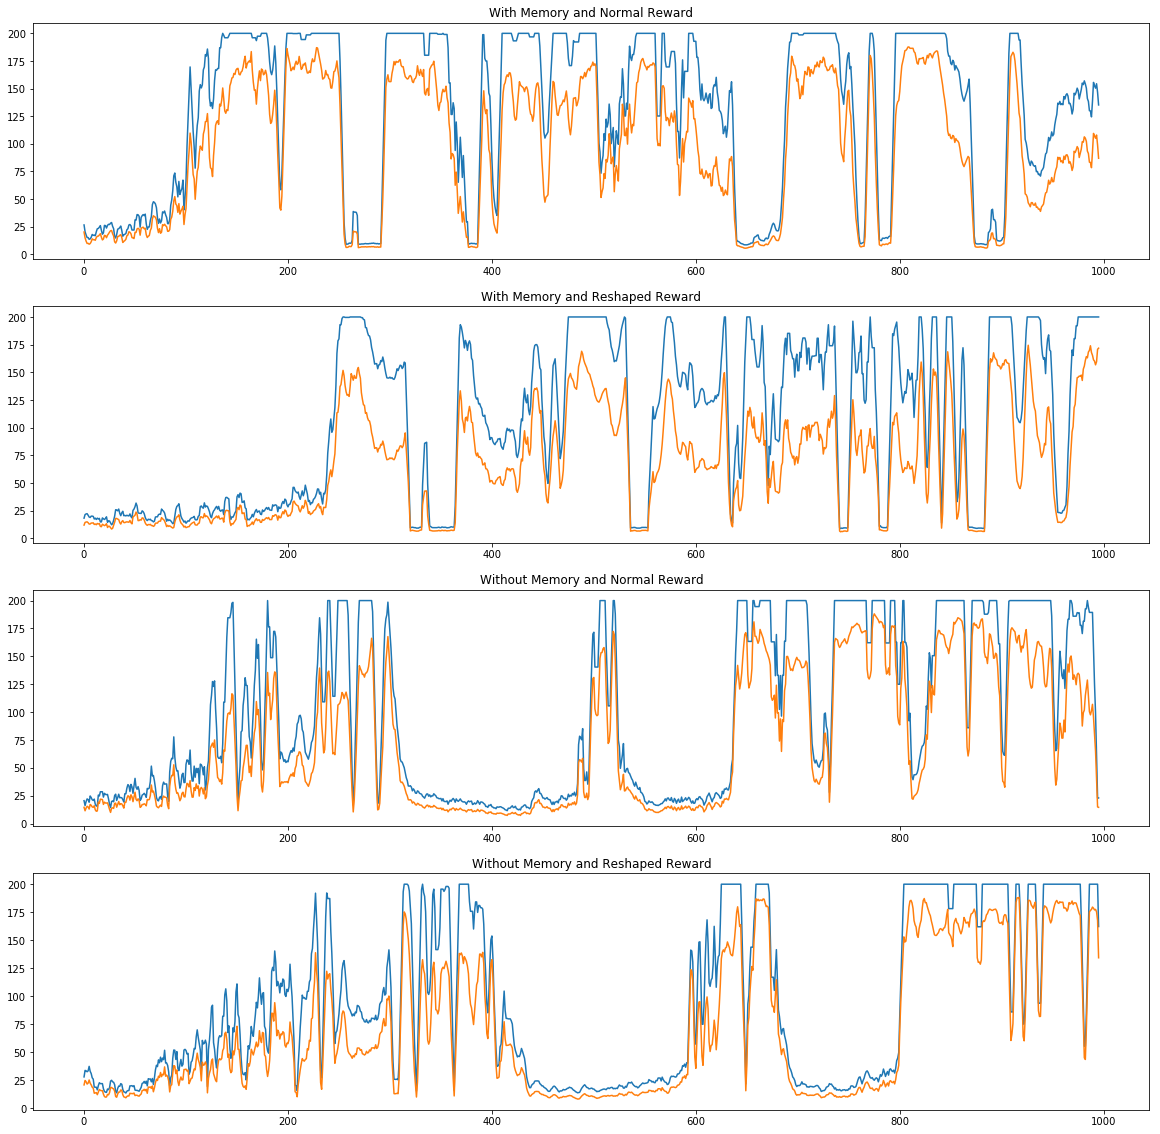

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(20,20))
data = [stat_1, stat_2, stat_3, stat_4]
titles = ["With Memory and Normal Reward",
          "With Memory and Reshaped Reward",
          "Without Memory and Normal Reward",
          "Without Memory and Reshaped Reward"]
for stat, axe, title in zip(data, axes, titles):
    simple_reward = list(zip(*stat.buffer))[1]
    dense_reward = list(zip(*stat.buffer))[2]
    axe.plot(moving_average(simple_reward, periods=5))
    axe.plot(moving_average(dense_reward, periods=5))
    axe.set_title(title)
plt.show()

We can see several drops. They can be explained by 3 points :
    
- The learning rate is too high and some bad actions taken in the past get rewarded for any reason so the policy got too impacted
- The replay memory/batch contains only states similar (because we succeed on several trials) and the model is highly overfitting those examples
- The exploration provides wrong decision multiple times leading to a lose

Below, you can see the result of the same training with a LR a lot smaller (0.0002)

In [24]:
with open( "DQN_with_memory_simple_reward_reduced_lr.p", "rb" ) as f:
    stat_1 = pickle.load(f)
with open( "DQN_with_memory_dense_reward_reduced_lr.p", "rb" ) as f:
    stat_2 = pickle.load(f)
with open( "DQN_without_memory_simple_reward_reduced_lr.p", "rb" ) as f:
    stat_3 = pickle.load(f)
with open( "DQN_without_memory_dense_reward_reduced_lr.p", "rb" ) as f:
    stat_4 = pickle.load(f)

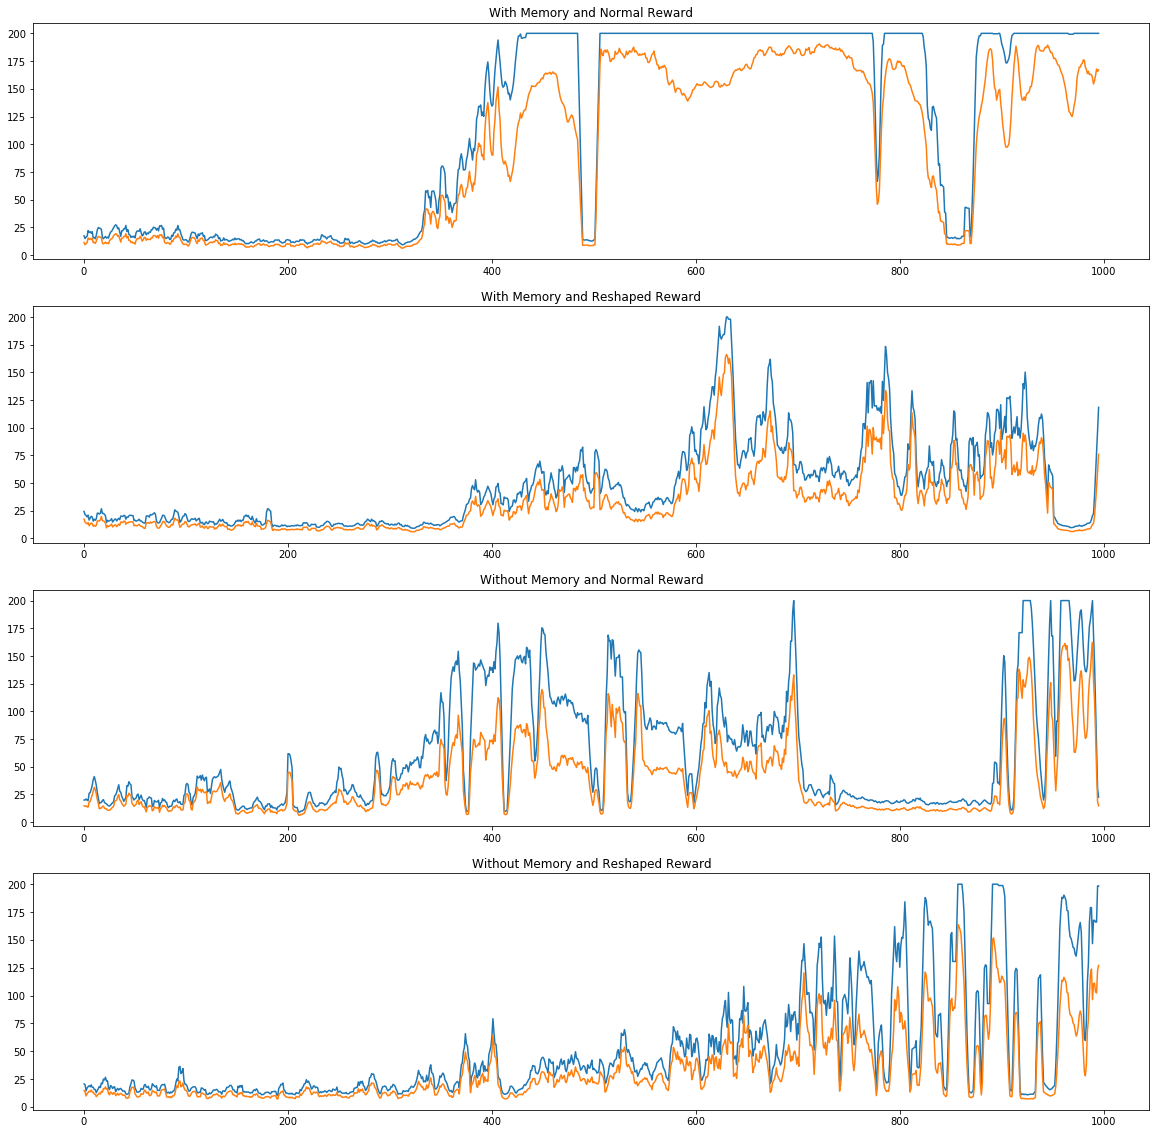

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(20,20))
data = [stat_1, stat_2, stat_3, stat_4]
titles = ["With Memory and Normal Reward",
          "With Memory and Reshaped Reward",
          "Without Memory and Normal Reward",
          "Without Memory and Reshaped Reward"]
for stat, axe, title in zip(data, axes, titles):
    simple_reward = list(zip(*stat.buffer))[1]
    dense_reward = list(zip(*stat.buffer))[2]
    axe.plot(moving_average(simple_reward, periods=5))
    axe.plot(moving_average(dense_reward, periods=5))
    axe.set_title(title)
plt.show()

We can see less drops because of a smaller learning rate so a bad action doesn't impact too much. Nevertheless, there is still huge drops after a series of success which can be explained by an overfitting of successfull episodes.

# Conclusion

In this Notebook, we discovered the DeepQ Network which is an improvement of Q-Learning saw few weeks ago. We also took a look at Replay Memory. We can easily see the benefit of this simple trick on previous results. Of course the model is not perfect, we may be able to learning faster with a Learning Rate Scheduler allowing to start with higher learning rate. We may be also able to regularize the model, adding dropouts, more layer/neurons to improve performances. Another point not tried yet is the "regularization" of reward presented in several papers. We will try this a future project regarding a QDN playing 2048.

I hope you enjoyed it !